Using device: cuda

Epoch 1/6
Train Loss: 0.8167, Acc: 0.6589, Prec: 0.6696, Recall: 0.6589, F1: 0.6626
Val   Loss: 0.6270, Acc: 0.7951, Prec: 0.8334, Recall: 0.7951, F1: 0.7859

Epoch 2/6
Train Loss: 0.6187, Acc: 0.8220, Prec: 0.8222, Recall: 0.8220, F1: 0.8221
Val   Loss: 0.5153, Acc: 0.8819, Prec: 0.8841, Recall: 0.8819, F1: 0.8826

Epoch 3/6
Train Loss: 0.5195, Acc: 0.8906, Prec: 0.8905, Recall: 0.8906, F1: 0.8905
Val   Loss: 0.5934, Acc: 0.8194, Prec: 0.8606, Recall: 0.8194, F1: 0.8155

Epoch 4/6
Train Loss: 0.4604, Acc: 0.9280, Prec: 0.9278, Recall: 0.9280, F1: 0.9278
Val   Loss: 0.3864, Acc: 0.9549, Prec: 0.9554, Recall: 0.9549, F1: 0.9548

Epoch 5/6
Train Loss: 0.4103, Acc: 0.9488, Prec: 0.9487, Recall: 0.9488, F1: 0.9487
Val   Loss: 0.3797, Acc: 0.9479, Prec: 0.9519, Recall: 0.9479, F1: 0.9483

Epoch 6/6
Train Loss: 0.3681, Acc: 0.9761, Prec: 0.9762, Recall: 0.9761, F1: 0.9761
Val   Loss: 0.3524, Acc: 0.9792, Prec: 0.9794, Recall: 0.9792, F1: 0.9791

✅ Training complete.


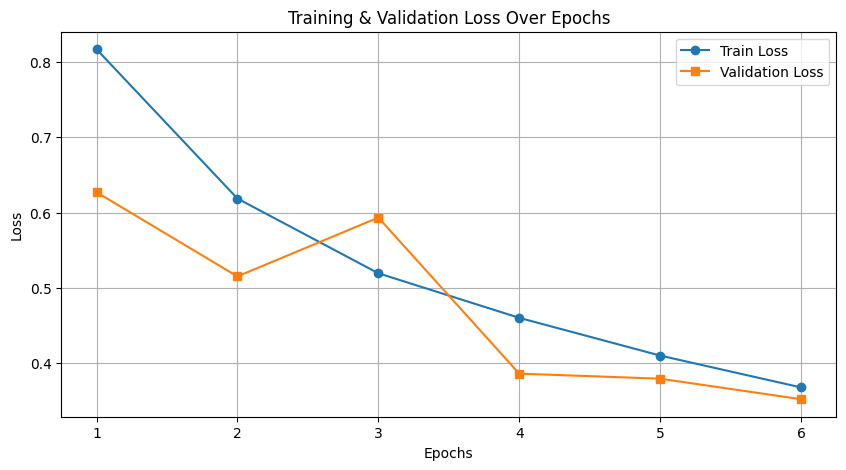

<ipython-input-2-99d0f8f5c66f>:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))



🔍 Test Dataset Metrics
✅ Accuracy: 0.9896
✅ Precision: 0.9899
✅ Recall: 0.9896
✅ F1 Score: 0.9896


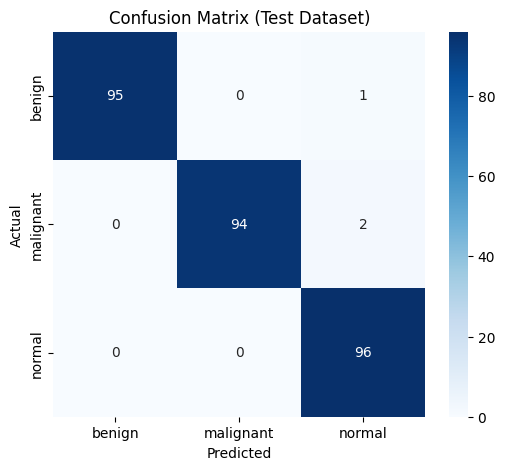

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dir = "/kaggle/input/lung-cancer-dataset1"

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=val_transform)

# Weighted sampler to handle class imbalance
targets = train_dataset.targets
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load Pretrained ResNet Model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(train_dataset.classes))
)
model = model.to(device)

# Updated: Label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Use OneCycleLR scheduler
from torch.optim.lr_scheduler import OneCycleLR
scheduler = OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=10)

train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

num_epochs =6
best_val_loss = float("inf")
early_stop_counter = 0
patience = 5

for epoch in range(num_epochs):
    model.train()
    train_loss, train_preds, train_labels = 0.0, [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_loss /= len(train_loader)
    train_acc = accuracy_score(train_labels, train_preds)
    train_prec = precision_score(train_labels, train_preds, average='weighted', zero_division=0)
    train_rec = recall_score(train_labels, train_preds, average='weighted', zero_division=0)
    train_f1 = f1_score(train_labels, train_preds, average='weighted', zero_division=0)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_prec = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    val_rec = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
    val_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)

    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Recall: {train_rec:.4f}, F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

print("\n✅ Training complete.")

# 📈 Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label="Train Loss", marker='o')
plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# 📊 Evaluate on Test Set
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))
model.eval()

test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

test_preds, test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(test_labels, test_preds)
test_prec = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
test_rec = recall_score(test_labels, test_preds, average='weighted', zero_division=0)
test_f1 = f1_score(test_labels, test_preds, average='weighted', zero_division=0)

print("\n🔍 Test Dataset Metrics")
print(f"✅ Accuracy: {test_acc:.4f}")
print(f"✅ Precision: {test_prec:.4f}")
print(f"✅ Recall: {test_rec:.4f}")
print(f"✅ F1 Score: {test_f1:.4f}")

# 📊 Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
class_names = test_dataset.classes

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Dataset)")
plt.show()


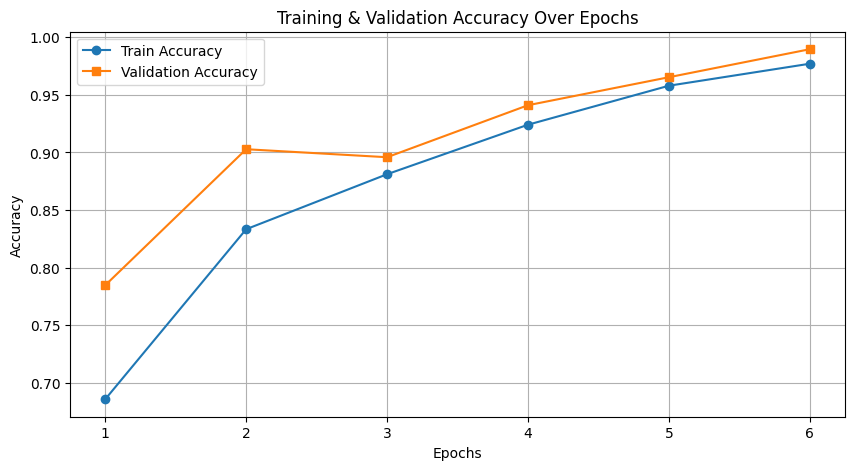

In [10]:
# 📈 Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label="Train Accuracy", marker='o')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label="Validation Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# 📋 Print Class-wise Accuracy
correct = np.zeros(len(class_names))
total = np.zeros(len(class_names))

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        for i in range(len(labels)):
            label = labels[i].item()
            pred = preds[i].item()
            if label == pred:
                correct[label] += 1
            total[label] += 1

print("\n📋 Class-wise Accuracy:")
for i, class_name in enumerate(class_names):
    accuracy = 100 * correct[i] / total[i] if total[i] > 0 else 0.0
    print(f"✅ {class_name}: {accuracy:.2f}%")



📋 Class-wise Accuracy:
✅ benign: 97.92%
✅ malignant: 100.00%
✅ normal: 98.96%


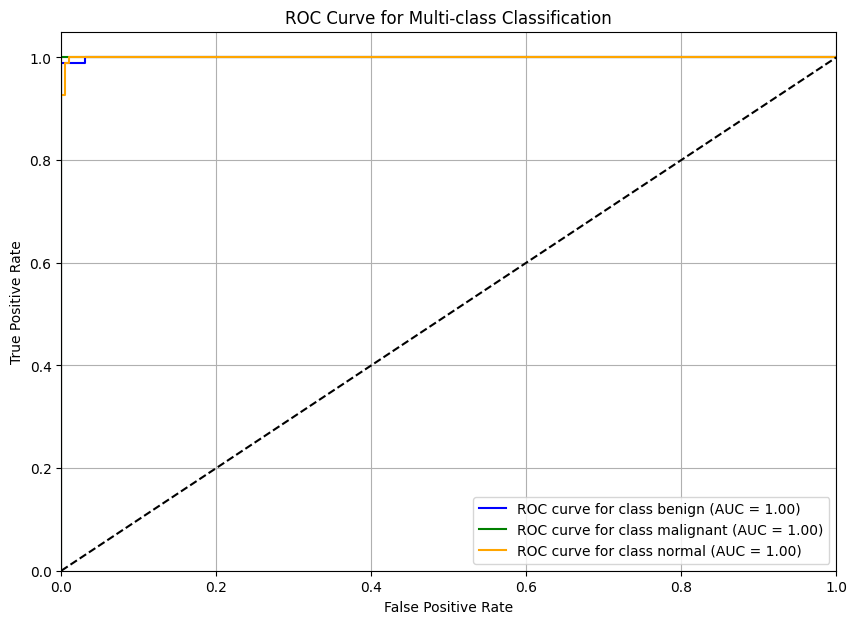

In [3]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get model outputs as probabilities for ROC Curve
model.eval()
test_probs = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Get probabilities
        test_probs.extend(probs.cpu().numpy())
        test_labels.extend(labels.numpy())

test_probs = np.array(test_probs)
test_labels = np.array(test_labels)

# Binarize the output for multi-class ROC
n_classes = len(test_dataset.classes)
test_labels_bin = label_binarize(test_labels, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)],
             label=f'ROC curve for class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-class Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
